# 🗺️ Workshop 3 Image Classification

> 🌻 María Fernanda López
> 
> 🌻 Megan García Antivar

## 1. Obtención de imágenes satelitales

A continuación se procede a realizar la descarga de un mosaico **Sentinel-2** en este caso para una zona específica de la Amazonía con temporalidad de un año para el 2018. De acuerdo con el artículo de González-González, Clerici y Quesada (2022).

In [7]:
pip install earthengine-api geemap geopandas

Note: you may need to restart the kernel to use updated packages.


El primer paso es la autenticación en Google Earth Engine. Antes de ejecutar cualquier código, es necesario asegurarse de reiniciar el kernel.

In [8]:
import ee
import geemap

# Solo la primera vez
ee.Authenticate()

# Inicia sesión en GEE
ee.Initialize()

A continuación se carga el shapefile, asegurándose que esté completo (`.shp`, `.shx`, `.dbf`, `.prj`) y en EPSG:4326. Luego usa este código para cargarlo:

In [9]:
import geopandas as gpd

# Cargar shapefile
gdf = gpd.read_file("/app/Geoprocesamiento/Workshop3_Image-Classification/Practica3/Workshop3_Image-Classification/ROI.shp")

# Asegúrate de que esté en EPSG:4326 (lat/lon)
gdf = gdf.to_crs(epsg=4326)

# Convertir a geojson
roi_json = gdf.geometry.union_all().__geo_interface__

# Crear geometría de EE
roi = ee.Geometry.Polygon(roi_json['coordinates']) if roi_json['type'] == 'Polygon' else ee.Geometry(roi_json)

Se realiza la función de enmascaramiento de nubes:

In [10]:
def maskS2clouds(image):
    # Select the QA60 band
    qa = image.select('QA60')

    # Bits 10 and 11 are cloud and cirrus confidence bands (1 == high confidence)
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask)

Se realiza la función de mosaico con los parámetros establecidos:

In [11]:
# Define the date range
start_date = '2018-01-01'
end_date = '2018-12-31'

bands_optical = ['B2', 'B3', 'B4', 'B5', 'B6',
                 'B7', 'B8', 'B8A', 'B11', 'B12'] 

# Load the Sentinel-2 image collection, filtered by date, bounds and cloudiness
#At the end you apply the function maskS2clouds to all the images in your iamge collection
#ad then it sorts by cloud cover
s2_img = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
          .filterBounds(roi)
          .filterDate("2018-01-01", "2018-12-31")  # cambiaste a 2018
          .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 50))
          .median()
          .select(bands_optical)
          .clip(roi))

Se obtiene la visualización del mosaico generado:

In [12]:
# Calcular percentiles 2 y 98 para las bandas B4, B3, B2
percentiles = s2_img.select(['B4', 'B3', 'B2']).reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=roi,
    scale=10,
    bestEffort=True
).getInfo()

# Definir los parámetros de visualización usando el stretch
vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': [
        percentiles['B4_p2'],
        percentiles['B3_p2'],
        percentiles['B2_p2']
    ],
    'max': [
        percentiles['B4_p98'],
        percentiles['B3_p98'],
        percentiles['B2_p98']
    ],
    'gamma': 1.6
}

# Crear mapa interactivo
Map = geemap.Map()

# Centrar en el área de interés
Map.centerObject(roi, 12)

# Agregar imagen Sentinel-2 con stretch aplicado
Map.addLayer(s2_img, vis_params, 'Sentinel-2 (stretch 2–98%)')

# Agregar la región de interés
Map.addLayer(roi, {}, 'AOI')

# Mostrar el mapa
Map

Map(center=[0.7438993852410466, -74.37883192530255], controls=(WidgetControl(options=['position', 'transparent…

A continuación se exporta la imagen a drive, para poder darle un manejo posterior.

In [141]:
task = ee.batch.Export.image.toDrive(
    image=s2_img,
    description='sentinel2',
    folder='Google Earth',
    fileNamePrefix='sentinel2_2018',
    region=roi,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
task.start()

## 2. Explicación de conceptos

Este notebook de Jupyter ofrece una experiencia práctica para aprender técnicas de clasificación de imágenes, tanto a nivel de píxeles como de objetos, utilizando las bibliotecas RSGISLib y scikit-learn. Está basado en los tutoriales creados por Pete Bunting. 

Durante el taller, se trabajará en las siguientes actividades:

1. **Preparación** de un conjunto reducido de imágenes Sentinel-2, incluyendo la combinación de bandas y el cálculo de índices espectrales.

2. **Entrenamiento** de modelos de Random Forest aplicados a datos por píxeles y por segmentos.

3. **Creación** de un mapa de cobertura del suelo utilizando reglas simples basadas en valores espectrales.

4. **Evaluación** de los resultados con un conjunto independiente de validación e interpretación de métricas de precisión.

Todos los productos generados —tanto intermedios como finales— se guardarán en formato **HDF5**, lo que facilita un manejo eficiente de los datos y permite incluir metadatos detallados.

---

### 📦 Qué es HDF5?

**HDF5 (Formato de Datos Jerárquico, versión 5)** es un estándar de archivo binario versátil diseñado para almacenar grandes volúmenes de datos científicos heterogéneos.

* **Estructura jerárquica**
Piensa en HDF5 como un sistema de archivos autosuficiente dentro de un solo archivo:

    * **Groups (Grupos)** = carpetas
    * **Datasets (Conjuntos de datos)** = archivos (matrices multidimensionales)
    * **Attributes (Atributos)** = metadatos tipo clave–valor adjuntos a grupos o conjuntos de datos

* **Características clave**  
  * Dimensiones ilimitadas (ideal para pilas de rásteres, series temporales, cubos hiperespectrales).  
  * **Compresión** incorporada (ej. `gzip`, `szip`), que ahorra espacio en disco sin archivos auxiliares externos.  
  * **Acceso aleatorio**: permite leer una pequeña porción sin cargar todo el archivo en memoria.  
  * **Seguro respecto al orden de bytes** (endianness)  y multiplataforma (Mac / Windows / Linux)  
  * Soporte nativo en Python (`h5py`, `xarray`), MATLAB, R, GDAL, QGIS y muchas bibliotecas de observación de la Tierra.

* **Por qué lo usamos aquí**  
  * Un solo archivo `.h5` almacena la imagen, las máscaras intermedias, las capas texturales **y** los resultados del modelo en un paquete portátil.  
  * Podemos adjuntar información de procedencia—nombre del sensor, fecha de adquisición, parámetros del clasificador—directamente en el archivo como atributos, garantizando que cualquier persona que abra los datos sepa exactamente cómo fueron generados.

---

### 👁️ Explorando archivos con HDFView**

Aunque los scripts en Python son perfectos para la automatización, un visor gráfico es invaluable cuando se trabaja por primera vez con un archivo HDF5 desconocido.  
Usaremos **HDFView** (el visor oficial del HDF Group):

1. **Descarga e instalación**  
   *Última versión*: <https://www.hdfgroup.org/download-hdfview/>  
   Elige el instalador para tu sistema operativo; el entorno Java viene incluido.

2. **Abrir un archivo**  
   *Archivo → Abrir* → selecciona `tu_dataset.h5`.  
   El panel izquierdo muestra el árbol de **grupos** y **conjuntos de datos**; el panel derecho previsualiza el contenido.

3. **Explorar los datasets**  
   * Haz doble clic sobre un dataset para ver los valores de la matriz.  
   * Usa la pestaña *Tabla* o *Imagen* para cambiar el modo de visualización (útil para rásteres 2D).  
   * Clic derecho → *Mostrar propiedades* para inspeccionar **atributos** (por ejemplo: sistema de referencia, longitud de onda).

4. **Ventajas para la enseñanza**  
   * Los estudiantes pueden **visualizar fácilmente** la estructura jerárquica y los metadatos sin escribir ni una línea de código.  
   * Revisión rápida del contenido (dimensiones, valores mínimos y máximos) antes de usar los datos en un modelo.  
   * Exportar fragmentos a CSV o PNG para usar en presentaciones.

---

### 📝 Metadatos que puedes registrar

| Categoría | Clave de atributo sugerida | Ejemplo de valor |
|----------|------------------------|---------------|
| Adquisición | `sensor`, `acq_date` | `"Sentinel-2 MSI"`, `"2024-07-12"` |
| Preprocesamiento | `atm_corr`, `indices` | `"Sen2Cor 2.10"`, `"NDVI, NDWI, NDBI"` |
| Detalles del clasificador | `model_type`, `rf_n_estimators`, `rf_max_depth` | `"RandomForest"`, `300`, `12` |
| Validación | `oa`, `kappa`, `macro_f1` | `0.88`, `0.84`, `0.85` |

Añadir atributos en Python con **h5py**:

```python
import h5py
with h5py.File("classified_map.h5", "a") as f:
    f.attrs["sensor"] = "Sentinel-2 MSI"
    f["/classification"].attrs["model_type"] = "RandomForest"

## 3. Importar módulos

In [28]:
# Import modules from python standard library
import os
import pprint
import random

# Import Geopandas and numpy for vector analysis (https://geopandas.org)
import geopandas as gpd
import numpy as np

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.imageutils
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

# Import rasterio
import rasterio
from rasterstats import point_query

## 4. Asignar los datos de entrada a variables

### Crear una máscara

In [14]:
# Abrir la imagen base solo para obtener dimensiones y metadata
input_img = '/app/Geoprocesamiento/Workshop3_Image-Classification/Practica3/Workshop3_Image-Classification/sentinel2_2018.tif'

with rasterio.open(input_img) as src:
    shape = (src.height, src.width)
    profile = src.profile

# Crear máscara binaria con todo a 1 (válido)
mask = np.ones(shape, dtype=np.uint8)

# Actualizar metadata para que sea archivo de una sola banda
profile.update({
    "count": 1,
    "dtype": 'uint8',
    "nodata": 0  # define explícitamente qué es inválido
})

# Guardar como GeoTIFF
with rasterio.open("/app/Geoprocesamiento/Workshop3_Image-Classification/Practica3/Workshop3_Image-Classification/sentinel2_2018_vmask.tif", "w", **profile) as dst:
    dst.write(mask, 1)

### Proyectar los datos

In [15]:
output_img = "/app/Geoprocesamiento/Workshop3_Image-Classification/Practica3/Workshop3_Image-Classification/sentinel2_2018_epsg3116.tif"

rsgislib.imageutils.gdal_warp(
    input_img=input_img,
    output_img=output_img,
    out_epsg=3116,
    interp_method=rsgislib.INTERP_BILINEAR,  # o BILINEAR si son valores continuos
    gdalformat="GTiff",
    use_multi_threaded=True,
    options=["TILED=YES", "COMPRESS=LZW", "BIGTIFF=YES"]
)

102it [00:23,  4.38it/s]                                                                                                


In [16]:
mask_img = "/app/Geoprocesamiento/Workshop3_Image-Classification/Practica3/Workshop3_Image-Classification/sentinel2_2018_vmask.tif"
output_img = "/app/Geoprocesamiento/Workshop3_Image-Classification/Practica3/Workshop3_Image-Classification/sentinel2_2018_vmask_3116.tif"

rsgislib.imageutils.gdal_warp(
    input_img=mask_img,
    output_img=output_img,
    out_epsg=3116,
    interp_method=rsgislib.INTERP_BILINEAR,  # o BILINEAR si son valores continuos
    gdalformat="GTiff",
    use_multi_threaded=True,
    options=["TILED=YES", "COMPRESS=LZW", "BIGTIFF=YES"]
)

102it [00:00, 158.87it/s]                                                                                               


In [17]:
# Ruta original y destino
input_gpkg = "/app/Geoprocesamiento/Workshop3_Image-Classification/Practica3/Workshop3_Image-Classification/Training.gpkg"
output_gpkg = "/app/Geoprocesamiento/Workshop3_Image-Classification/Practica3/Workshop3_Image-Classification/Training_data_epsg3116.gpkg"

# Leer archivo original
gdf = gpd.read_file(input_gpkg)

# Reproyectar a MAGNA-SIRGAS / Colombia Bogotá
gdf_3116 = gdf.to_crs(epsg=3116)

# Guardar como nuevo GPKG
gdf_3116.to_file(output_gpkg, driver="GPKG")

In [1]:
input_img = "data/Workshop_3/sentinel2_2018_epsg3116.tif"
in_msk_img = "data/Workshop_3/sentinel2_2018_vmask_3116.tif"
vec_train_file = "data/Workshop_3/Training_data_epsg3116.gpkg"

In [19]:
# Call function to get the input image resolution:
x_res, y_res = rsgislib.imageutils.get_img_res(input_img)
print(f"Image Resolution: ({round(x_res, 2)}, {round(y_res,2)}) m")

Image Resolution: (9.98, -9.98) m


In [20]:
# Call function to get the input image resolution:
x_res, y_res = rsgislib.imageutils.get_img_res(in_msk_img)
print(f"Image Resolution: ({round(x_res, 2)}, {round(y_res,2)}) m")

Image Resolution: (9.98, -9.98) m


Declara las entradas principales para el ejercicio de clasificación:

| Variable         | Archivo                                                 | Propósito                                                                                                                                                                                                                                                              |
| ---------------- | ------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `input_img`      | `sentinel2_2018_epsg3116.tif`      | Escena multiespectral Sentinel-2 (resolución espacial de 9.98 m) que será clasificada. El archivo ya ha sido corregido a reflectancia de superficie y está proyectado al sistema de coordenadas colombiano (EPSG 3116).                                            |
| `in_msk_img`     | `sentinel2_2018_vmask_3116.tif` | Máscara de píxeles válidos para la misma escena. Identifica los píxeles que deben ser ignorados (nubes, bordes, huecos del detector). Para este subconjunto, todos los píxeles resultan ser válidos, pero las rutinas de RSGISLib aún requieren una máscara explícita. |
| `vec_train_file` | `Training_data_epsg3116.gpkg`                           | Capa vectorial que contiene los puntos de entrenamiento (o pequeños polígonos). Cada registro está etiquetado con un ID de clase de cobertura del suelo; los valores espectrales bajo estos puntos entrenarán el clasificador Random Forest y SVM.                           |


> #### **¿Por qué molestarse en usar una máscara?**
> Incluso cuando toda la imagen parece válida, muchas cadenas de procesamiento de observación de la Tierra esperan una máscara complementaria para poder manejar sin problemas escenas con nubes o líneas faltantes. Proporcionar una ahora asegura que el mismo flujo de trabajo exacto funcione más adelante sobre imágenes menos limpias.

Las muestras se definen utilizando capas vectoriales de polígonos. Cada atributo representa una clase, y dentro de esa capa se utilizan múltiples polígonos o puntos para identificar los píxeles que pertenecen a la clase de interés. Ten en cuenta que la capa vectorial debe estar en la misma proyección que la(s) imagen(es) de entrada. 

Recuerda que, al definir tu conjunto de datos de referencia, debes asegurarte de obtener un número similar de píxeles muestreados para todas las clases. Esto puede ser problemático para clases que tienen una cobertura geográfica limitada. Sin embargo, también debes procurar tener una buena cobertura geográfica y evitar tener pocos polígonos grandes todos ubicados en una misma zona — esto puede resultar en una sobreestimación de la precisión del clasificador debido al sobreajuste causado por autocorrelación espacial.

Para este análisis, se utilizará el siguiente archivo Geopackage (GPKG) que contiene una capa que definen los datos de entrenamiento. Abre las capas en un SIG y examínalas antes de continuar con el tutorial. Después de terminar el tutorial, podrías considerar revisar estos datos de referencia, volver a ejecutar las clasificaciones y comparar los resultados para ver qué diferencia produce.

## 5. Explorar los datos

### Exportar cada una de las clases a una única capa

Para seguir el ejercicio es correcto que cada una de las clases de coberturas este en una sola capa. Por ello, a continuación se procede a extraer esta información.

In [9]:
# Leer la capa original
gdf = gpd.read_file("data/Workshop_3/Training_data_epsg3116.gpkg", layer="training_data_epsg3116")

print(gdf.columns)
print(gdf["Name"].unique())

Index(['Name', 'descriptio', 'timestamp', 'begin', 'end', 'altitudeMo',
       'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'landcover',
       'system_ind', 'geometry'],
      dtype='object')
['Water_bodies' 'Agricultural_areas' 'sparsely or no vegetated areas'
 'Forest' 'Secondary_vegetation']


In [10]:
# Ruta de salida
output_gpkg = "data/Workshop_3/Training_data_epsg3116.gpkg"

# Nombre de la columna que contiene las clases
clase_col = "Name" 

# Iterar por clase y guardar como capa individual
for clase in gdf[clase_col].unique():
    sub_gdf = gdf[gdf[clase_col] == clase]
    sub_gdf.to_file(output_gpkg, layer=clase.replace(" ", "_"), driver="GPKG")

Obtén la lista de capas dentro del archivo vectorial:

In [23]:
lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)
print(lyr_names )

['Water_bodies', 'sparsely_or_no_vegetated_areas', 'Secondary_vegetation', 'Training_data_epsg3116', 'Artificial_surfaces', 'Agricultural_areas', 'Forest', 'Shurb_and_herbaceous']


### Visualizar los datos de entrenamiento

Se recomienda abrir la imagen de entrada (sentinel2_2018.tif) y las muestras de entrenamiento (vec_train_file.gpkg) en QGIS (u otro visor SIG) para observar las regiones que han sido definidas para el entrenamiento, ya que esto te permite navegar (hacer pan y zoom) de forma más libre sobre los datos.

Sin embargo, a continuación se muestra una visualización general a modo ilustrativo. Si modificas el bounding box, puedes desplazarte y acercarte dentro de la escena. Ten en cuenta que las muestras de entrenamiento son bastante pequeñas en comparación con toda la escena y por eso pueden ser difíciles de ver.

In [24]:
# Get the full image bounding box.
img_bbox = rsgislib.imageutils.get_img_bbox(input_img)
print(img_bbox)

(944712.7306693317, 988204.5931766616, 557628.0093751058, 590426.4598164133)


La siguiente celda crea un único mapa que superpone nuestro **mosaico de Sentinel-2** con los **puntos o polígonos de entrenamiento**. El objetivo es confirmar que cada muestra realmente se encuentra sobre su tipo de cobertura del suelo correspondiente.

* **📦 Cuadro delimitador (Bounding box)**

Recorta la visualización al área `sub_img_bbox = [953958.66, 978958.66, 561527.23, 586527.23]` (mín-x, máx-x, mín-y, máx-y en metros). Esta ventana de 25 km × 25 km mantiene la figura compacta, pero aún así abarca todas las capas de entrenamiento.

* **🛰️ Imagen base (bandas 8-9-3)**

`rsgislib.tools.mapping.create_raster_img_map` dibuja una composición pseudo-RGB utilizando las bandas 8 (NIR), 9 (borde rojo) y 3 (verde) de Sentinel-2. Se aplica un estiramiento de histograma acumulado para mejorar el contraste local, y se añade automáticamente una barra de escala.

* **🎨 Colores aleatorios para cada clase de cobertura**

Se obtiene toda la paleta CSS4 de Matplotlib (`mcolors.CSS4_COLORS`) y se asigna un color aleatorio distinto a cada capa listada en lyr_names. Esto garantiza que las clases sean visualmente distinguibles sin necesidad de elegir colores manualmente.

* **📚 Carga de las capas de entrenamiento**

Cada capa del archivo `vec_train_file` (GeoPackage o Shapefile) se carga en un GeoDataFrame de GeoPandas, y se almacena en gp_vecs, lista para ser graficada.

* **🗺️ Superposición vectorial**
  
`create_vec_lyr_map` dibuja todas las capas de entrenamiento en un solo comando, utilizando los colores aleatorios seleccionados y un borde negro delgado. El bounding box asegura que la superposición coincida perfectamente con el subset del ráster. La segunda barra de escala se suprime para evitar saturación visual.

**¿Por qué hacer esto?**

Antes de ejecutar cualquier algoritmo de aprendizaje automático, debemos asegurarnos de que:

1. El subset de la imagen realmente cubre todos los puntos de entrenamiento.
2. Ninguna muestra cae sobre nubes, artefactos de borde o fuera de la máscara de píxeles válidos.
3. La composición espectral se ve razonable (sin bandas desalineadas, estiramiento correcto).

Una inspección rápida de esta figura puede ahorrar mucho tiempo de procesamiento malgastado más adelante.

> **🔍 Experimenta con combinaciones de bandas:**

>Cambia `img_bands = [8, 9, 3]` por otro trío, por ejemplo: `[11, 8, 4]` (SWIR–NIR–Rojo) o `[12, 11, 4]` y observa cómo se comportan la vegetación, las áreas urbanas y los cuerpos de agua.

En `gpd.read_file`, el argumento layer le indica a GeoPandas qué capa vectorial del archivo se debe cargar. Un Shapefile solo contiene una capa, por lo que layer= es ignorado.

Un GeoPackage (.gpkg) o archivo MapInfo TAB puede contener varias capas, es decir, múltiples conjuntos de datos dentro de un solo contenedor. Por eso, debes especificar cuál deseas cargar.

En este notebook, `lyr_names` es una lista de cadenas, cada una con el nombre exacto de una capa específica por clase dentro del archivo `vec_train_file`.

Image Data Size: 4360 x 3288


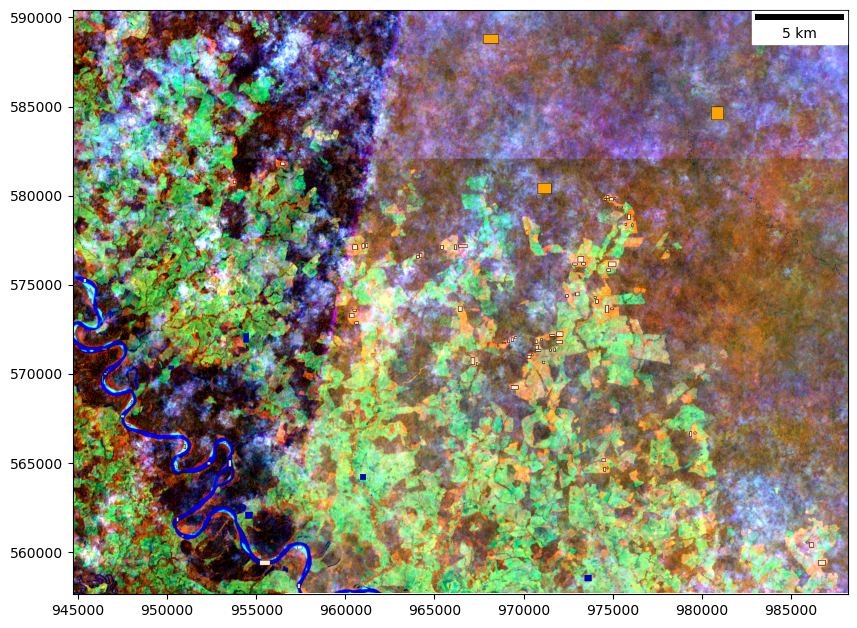

In [25]:
# ---------------------------------------------------------
# 1. Define the map window using four OSGB coordinates: xmin, xmax, ymin, ymax (metres).
sub_img_bbox = [944712.7306693317, 988204.5931766616, 557628.0093751058, 590426.4598164133]
# ---------------------------------------------------------
# 2. Prepare a Matplotlib canvas
#    One axis, 10 × 10 inches – large enough for legible detail.
fig, ax = plt.subplots(figsize=(10, 10))
# ---------------------------------------------------------
# 3. Draw a Sentinel-2 RGB composite
#    * input_img       : full multispectral stack
#    * img_bands       : [8 (NIR), 9 (red-edge), 3 (green)]
#    * img_stch        : cumulative histogram stretch for contrast
#    * bbox            : clip to the subset
#    * show_scale_bar  : adds a 5 km bar bottom-left
# ---------------------------------------------------------
rsgislib.tools.mapping.create_raster_img_map(
    ax,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)

# ---------------------------------------------------------
# 4. Build a palette of distinct colours
#    CSS4 provides ~140 named colours; we convert the dict keys
#    to a list so random.choice can pick from it.
mpl_clrs = list(mcolors.CSS4_COLORS.keys())

# Lists to store GeoPandas layers and their display colours
gp_vecs  = []
lyr_clrs = []

# ---------------------------------------------------------
# 5. Load each training layer and assign a random colour
#    * lyr_names        : list of class layers in the GeoPackage
#    * vec_train_file   : path to the training samples (GPKG)
for lyr_name in lyr_names:
    # Read the class layer as a GeoDataFrame
    gp_vecs.append(geopandas.read_file(vec_train_file, layer=lyr_name))
    # Pick a random CSS colour to fill that class
    lyr_clrs.append(random.choice(mpl_clrs))

# ---------------------------------------------------------
# 6. Overlay the training vectors on the RGB image
#    * gp_vecs         : list of GeoDataFrames (one per class)
#    * vec_fill_clrs   : matching list of fill colours
#    * vec_line_clrs   : outline colour (“black” for all)
#    * bbox            : ensures vectors are clipped to the subset
#    * show_scale_bar  : False – we already drew one above
# ---------------------------------------------------------
rsgislib.tools.mapping.create_vec_lyr_map(
    ax,
    gp_vecs=gp_vecs,
    bbox=sub_img_bbox,
    vec_fill_clrs=lyr_clrs,
    vec_line_clrs="black",
    show_scale_bar=False,
)

## 6. Extraer muestras de entrenamiento

Para el análisis, los valores individuales de los píxeles se extraen y se almacenan en un archivo HDF5, lo que permite guardar y manipular esos datos (por ejemplo, los valores de píxeles provenientes de múltiples imágenes pueden combinarse).

Para extraer las muestras de entrenamiento (es decir, los valores individuales de los píxeles) utilizando la capa vectorial definida, primero es necesario rasterizar las capas vectoriales para que coincidan con la misma cuadrícula de píxeles de la(s) imagen(es) de entrada. Para simplificar este proceso, se ha proporcionado una función auxiliar:
`rsgislib.classification.get_class_training_data`.

### Definir imágenes y bandas para la clasificación

Antes de poder extraer los valores de los píxeles o realizar la clasificación, es necesario definir las imágenes relevantes y las bandas dentro de esas imágenes. Es fundamental que estas definiciones sean idénticas tanto para la extracción de las muestras como para el paso de clasificación.

Si no se definen de manera idéntica, el clasificador entrenado no funcionará como se espera, lo que probablemente resultará en muy malos resultados de clasificación.

Para definir las imágenes y bandas, se proporciona una lista de objetos `rsgislib.imageutils.ImageBandInfo` a las funciones correspondientes de RSGISLib.
Consulta el [enlace](http://rsgislib.org/rsgislib_imageutils.html#rsgislib.imageutils.ImageBandInfo) para entender mejor la clase `rsgislib.imageutils.ImageBandInfo`.

In [46]:
img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)
print(img_band_info)

[('sen2', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'data/Workshop_3/sentinel2_2018_epsg3116.tif')]


### Definir las clases y las muestras vectoriales

La rutina auxiliar de Random Forest espera una **lista de objetos `ClassVecSamplesInfoObj`** —uno por cada clase de cobertura del suelo. Cada objeto le indica a RSGISLib dónde obtener los vectores de entrenamiento y dónde almacenar los valores de los píxeles extraídos.

| Parámetro    | Significado                                                                                                                                                  | Nota práctica |
| ------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------ | ------------- |
| `id`         | Etiqueta entera que se escribirá en el ráster clasificado. Mantén la secuencia compacta (por ejemplo, del 1 al 10) para facilitar la reasignación posterior. |               |
| `class_name` | Nombre corto, legible por máquina (en minúsculas y con guiones bajos). Se usa como nombre de grupo dentro del archivo HDF5 de muestras.                      |               |
| `vec_file`   | Ruta al archivo GeoPackage que contiene todas las capas de entrenamiento.                                                                                    |               |
| `vec_lyr`    | Nombre exacto de la capa dentro del GeoPackage para esta clase.                                                                                              |               |
| `file_h5`    | Nombre del archivo HDF5 que RSGISLib creará para almacenar las muestras de píxeles extraídas (un archivo por clase mantiene el orden).                       |               |

La siguiente celda instancia cinco objetos de este tipo —uno por cada clase temática de nuestra leyenda— y los agrega a la lista `class_vec_sample_info`.

Puedes agregar o eliminar entradas libremente, siempre que los IDs sean únicos y los nombres de las capas vectoriales coincidan exactamente con los que están en el archivo GeoPackage.

In [48]:
class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
agricultural_areas_h5 = "agricultural_areas_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="Agricultural_areas",
        vec_file=vec_train_file,
        vec_lyr="Agricultural_areas",
        file_h5=agricultural_areas_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
forest_h5 = "forest_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="Forest",
        vec_file=vec_train_file,
        vec_lyr="Forest",
        file_h5=forest_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
secondary_vegetation_h5 = "secondary_vegetation_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="Secondary_vegetation",
        vec_file=vec_train_file,
        vec_lyr="Secondary_vegetation",
        file_h5=secondary_vegetation_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
sparsely_no_veg_h5 = "sparsely_no_veg_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="sparsely or no vegetated areas",
        vec_file=vec_train_file,
        vec_lyr="sparsely_or_no_vegetated_areas",
        file_h5=sparsely_no_veg_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
water_bodies_h5 = "water_bodies_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="Water_bodies",
        vec_file=vec_train_file,
        vec_lyr="water_bodies",
        file_h5=water_bodies_h5,
    )
)

## See what is inside  class_vec_sample_info
print(class_vec_sample_info)

[<rsgislib.classification.ClassVecSamplesInfoObj object at 0x75847d161a10>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x75847d398e10>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x75847d2a0e50>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x75847d163ad0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x75847d161e90>]


Cuando haces `print()` sobre un objeto `ClassVecSamplesInfoObj`, solo obtienes la salida predeterminada de Python: `<rsgislib.classification.ClassVecSamplesInfoObj object at 0x…>`, lo cual no es más que la dirección de memoria del objeto. Para ver el **contenido real del objeto**, necesitamos consultar sus atributos directamente.

El siguiente bloque de código:

1. Almacena la primera entrada de la lista (`class_vec_sample_info[0]`) en una variable llamada `obj`.
2. Llama a `**vars(obj)**` (o, de forma equivalente, `obj.__dict__)` para mostrar todos sus atributos como un diccionario de Python ordenado.

Esto permite ver con total claridad qué `id`, `class_name`, capa vectorial y nombre de archivo HDF5 están asociados con esa clase de entrenamiento.

In [49]:
obj = class_vec_sample_info[0]
vars(obj)        # returns a dictionary of attributes
# or
obj.__dict__

{'id': 1,
 'class_name': 'Agricultural_areas',
 'vec_file': 'data/Workshop_3/Training_data_epsg3116.gpkg',
 'vec_lyr': 'Agricultural_areas',
 'file_h5': 'agricultural_areas_smpls.h5'}

**¿Qué hace realmente `obj.__dict__`?**

Todo objeto "normal" en Python mantiene sus **atributos de instancia** en un diccionario oculto llamado `__dict__`.
Cuando accedes o asignas `obj.algun_atributo`, Python en realidad está haciendo una búsqueda o actualización dentro de ese diccionario.

Por lo tanto, al llamar a `obj.__dict__` se devuelve un `diccionario` activo que contiene todos los atributos definidos por el usuario y sus valores actuales:

```python
{
    'id'        : 1,
    'class_name': 'Agricultural_areas',
    'vec_file'  : 'data/Workshop_3/Training_data_epsg3116.gpkg',
    'vec_lyr'   : 'Agricultural_areas',
    'file_h5'   : 'agricultural_areas_smpls.h5'
}

### Crear un directorio temporal de salida

La función auxiliar requiere un directorio donde se escribirán salidas temporales (por ejemplo, capas vectoriales rasterizadas) durante el procesamiento.

El siguiente código verifica si el directorio ya existe y, en caso de que no, lo crea:

In [50]:
tmp_dir = "./tmp"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

### Realizar la extracción de muestras

El siguiente paso utilizará la función auxiliar `rsgislib.classification.get_class_training_data` para extraer los datos de muestra.

In [51]:
cls_smpls_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_info, tmp_dir, ref_img=in_msk_img
)

Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Consulta el objeto de información de muestras de clase que se ha retornado.

In [52]:
# Output the returned class samples info object 
cls_smpls_info

{'Agricultural_areas': 1: agricultural_areas_smpls.h5, (147, 203, 168),
 'Forest': 2: forest_smpls.h5, (26, 50, 140),
 'Secondary_vegetation': 3: secondary_vegetation_smpls.h5, (211, 78, 236),
 'sparsely or no vegetated areas': 4: sparsely_no_veg_smpls.h5, (140, 235, 135),
 'Water_bodies': 5: water_bodies_smpls.h5, (48, 11, 10)}

### Definir los colores de las clases

Es útil definir manualmente los colores para las clases, ya que esto facilita mucho la interpretación del mapa por parte del usuario final.
Los colores se definen como valores Rojo, Verde y Azul (RGB) entre 0 y 255.

Existen muchas herramientas (por ejemplo, RapidTables) para buscar colores en línea (intenta buscar “Selector de color” o “Colour picker”).

In [53]:
cls_smpls_info["Agricultural_areas"].red = 252
cls_smpls_info["Agricultural_areas"].green = 232
cls_smpls_info["Agricultural_areas"].blue = 109

cls_smpls_info["Forest"].red = 0
cls_smpls_info["Forest"].green = 105
cls_smpls_info["Forest"].blue = 16

cls_smpls_info["Secondary_vegetation"].red = 0
cls_smpls_info["Secondary_vegetation"].green = 153
cls_smpls_info["Secondary_vegetation"].blue = 153

cls_smpls_info["sparsely or no vegetated areas"].red = 156
cls_smpls_info["sparsely or no vegetated areas"].green = 255
cls_smpls_info["sparsely or no vegetated areas"].blue = 215

cls_smpls_info["Water_bodies"].red = 0
cls_smpls_info["Water_bodies"].green = 0
cls_smpls_info["Water_bodies"].blue = 255

cls_smpls_info

{'Agricultural_areas': 1: agricultural_areas_smpls.h5, (252, 232, 109),
 'Forest': 2: forest_smpls.h5, (0, 105, 16),
 'Secondary_vegetation': 3: secondary_vegetation_smpls.h5, (0, 153, 153),
 'sparsely or no vegetated areas': 4: sparsely_no_veg_smpls.h5, (156, 255, 215),
 'Water_bodies': 5: water_bodies_smpls.h5, (0, 0, 255)}

### ¿Cuántas muestras de entrenamiento se extrajeron?

**🔍 Verificación rápida del número de muestras**

Antes de entrenar el clasificador, es una buena práctica confirmar cuántas muestras de píxeles se han extraído realmente para cada clase de cobertura del suelo.

El ciclo en la siguiente celda realiza ese diagnóstico en cuatro pasos sencillos:

**1. Iterar sobre el diccionario de clases**

`cls_smpls_info` es un diccionario cuyas claves son los nombres de las clases (por ejemplo, "water", "scrub", etc.) y cuyos valores son los objetos `ClassVecSamplesInfoObj` correspondientes que definiste anteriormente.

**2. Obtener el archivo HDF5 de cada clase**

Para cada clave (`cls_name`) se recupera file_h5, que es la ruta al archivo `.h5` que contiene las muestras espectrales de esa clase (por ejemplo, `"water_smpls.h5"`).

**3. Contar las muestras**

`rsgislib.classification.get_num_samples()` abre el archivo HDF5, accede al conjunto de datos de muestras en su interior y devuelve el número de filas/píxeles almacenados.

**4. Imprimir un resumen ordenado**

La función `print()` produce una salida como:

`water: 3124`
`scrub: 587`

Esto te permite detectar fácilmente clases vacías, desbalance extremo o conjuntos de muestras inesperadamente grandes.

>**¿Por qué es útil?**
>* Asegura que ninguna clase fue omitida por un error en el nombre de la capa.
>* Destaca el desbalance entre clases, lo que te permite corregirlo antes de entrenar el modelo.
>* Da una idea aproximada del tiempo de entrenamiento:
>   * Miles de muestras por clase suelen estar bien.
>   * Decenas de miles podrían requerir submuestreo (down-sampling).

In [54]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

Agricultural_areas: 10061
Forest: 80391
Secondary_vegetation: 21150
sparsely or no vegetated areas: 1368
Water_bodies: 4321


Observando el número de muestras disponibles para las clases, hay varias cosas que podrían hacerse:
Primero, las muestras deberían estar balanceadas (es decir, el mismo número por clase), y esto requeriría usar la clase con el menor número de muestras como referencia para definir la cantidad de muestras para entrenamiento, validación y prueba.

Alternativamente, los datos de muestra pueden ser sobremuestreados (oversampling), o también existen algoritmos que intentan generar muestras de entrenamiento artificiales (consulta las funciones dentro del módulo `rsgislib.classification.classimblearn`, que hace uso de la librería imbalanced-learn).

Para este tutorial, se mantendrá la configuración simple, y se usará la clase con menor número de muestras (`sparsely or no vegetated areas`) como referencia para definir el número de muestras por clase:

* Entrenamiento: 1000
* Validación: 130
* Prueba: 130

Las muestras se seleccionan aleatoriamente de la población de muestras de entrada.

### Balancear y extraer los conjuntos de datos de entrenamiento, validación y prueba

Nuevamente se proporciona una función auxiliar —`rsgislib.classification.create_train_valid_test_sets`— que simplifica este análisis.
Para utilizarla, se necesita definir una lista de objetos `rsgislib.classification.ClassInfoObj`, que especifican los nombres de los archivos HDF5 para entrenamiento, validación y prueba.

Después de extraer las muestras de píxeles crudas para cada clase, debemos dividirlas en tres subconjuntos independientes:

| Subconjunto       | Propósito                                                 |
| ----------------- | --------------------------------------------------------- |
| **Entrenamiento** | Ajustar los parámetros del modelo Random Forest.          |
| **Validación**    | Ajustar hiperparámetros, detectar sobreajuste.            |
| **Prueba**        | Proporcionar una métrica de precisión imparcial al final. |

RSGISLib ofrece dos funciones auxiliares convenientes que automatizan este flujo de trabajo:

1. **`get_class_info_dict`**

Convierte el diccionario actual de **`ClassSimpleInfoObj`** (un archivo HDF5 con *todas* las muestras por clase) en un diccionario de **`ClassInfoObj`**, que ya incluye *tres* nombres de archivo HDF5 por clase: `*_train.h5`, `*_valid.h5`, `*_test.h5`.

3. **`create_train_valid_test_sets`**

Lee esos nombres de archivo, divide las muestras en consecuencia y guarda los tres archivos resultantes.

La celda que sigue realiza el paso 1:

* Se define un directorio de salida (`smpls_dir`) donde se escribirán los archivos divididos.
* `get_class_info_dict(cls_smpls_info, smpls_dir)` recorre cada entrada en `cls_smpls_info`, agrega los sufijos `_train`, `_valid` y `_test` al nombre del archivo original de muestras, y devuelve el nuevo diccionario **`cls_smpls_fnl_info`**.

In [55]:
# Define the output directory and create if it does not exist:
smpls_dir = "./cls_smpls"

if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)


cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, smpls_dir
)

print("\n keys",cls_smpls_fnl_info.keys())

# print the values of artificail_surfaces
print("\n keys",cls_smpls_fnl_info["sparsely or no vegetated areas"])

0=1: (Train:./cls_smpls/agricultural_areas_smpls_train.h5, Test:./cls_smpls/agricultural_areas_smpls_test.h5, Valid:./cls_smpls/agricultural_areas_smpls_valid.h5), (252, 232, 109)
1=2: (Train:./cls_smpls/forest_smpls_train.h5, Test:./cls_smpls/forest_smpls_test.h5, Valid:./cls_smpls/forest_smpls_valid.h5), (0, 105, 16)
2=3: (Train:./cls_smpls/secondary_vegetation_smpls_train.h5, Test:./cls_smpls/secondary_vegetation_smpls_test.h5, Valid:./cls_smpls/secondary_vegetation_smpls_valid.h5), (0, 153, 153)
3=4: (Train:./cls_smpls/sparsely_no_veg_smpls_train.h5, Test:./cls_smpls/sparsely_no_veg_smpls_test.h5, Valid:./cls_smpls/sparsely_no_veg_smpls_valid.h5), (156, 255, 215)
4=5: (Train:./cls_smpls/water_bodies_smpls_train.h5, Test:./cls_smpls/water_bodies_smpls_test.h5, Valid:./cls_smpls/water_bodies_smpls_valid.h5), (0, 0, 255)

 keys dict_keys(['Agricultural_areas', 'Forest', 'Secondary_vegetation', 'sparsely or no vegetated areas', 'Water_bodies'])

 keys 3=4: (Train:./cls_smpls/sparsely_n

> Ten en cuenta que, hasta ahora, no se ha creado ningún archivo HDF5 con los datos de entrenamiento, prueba o validación.

> Una vez que se crea `cls_smpls_fnl_info`, el bloque de código siguiente llamará a `create_train_valid_test_sets` para realizar la división estratificada real.

Ejecuta la función auxiliar `create_train_valid_test_sets` para crear los conjuntos de datos de entrenamiento, validación y prueba.

In [56]:
# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 130, 130, 1000
)

In [57]:
print("Muestras finales por clase (entrenamiento / validación / prueba):\n")

for clase, info in cls_smpls_fnl_info.items():
    n_train = rsgislib.classification.get_num_samples(info.train_file_h5)
    n_valid = rsgislib.classification.get_num_samples(info.valid_file_h5)
    n_test = rsgislib.classification.get_num_samples(info.test_file_h5)

    print(f"🔸 {clase}")
    print(f"   Entrenamiento : {n_train}")
    print(f"   Validación    : {n_valid}")
    print(f"   Prueba        : {n_test}\n")

Muestras finales por clase (entrenamiento / validación / prueba):

🔸 Agricultural_areas
   Entrenamiento : 1009
   Validación    : 139
   Prueba        : 131

🔸 Forest
   Entrenamiento : 1041
   Validación    : 161
   Prueba        : 161

🔸 Secondary_vegetation
   Entrenamiento : 1002
   Validación    : 148
   Prueba        : 148

🔸 sparsely or no vegetated areas
   Entrenamiento : 1001
   Validación    : 131
   Prueba        : 131

🔸 Water_bodies
   Entrenamiento : 1004
   Validación    : 134
   Prueba        : 134



Ahora tienes tres archivos HDF5 por cada clase (puedes verlos dentro del directorio `cls_smpls`), los cuales definen los píxeles extraídos de la escena para entrenar, validar y probar el clasificador.

Si quieres ver el contenido de uno de estos archivos HDF5, puedes usar el comando h5dump como se muestra a continuación. (Nota: cuando usas un cuaderno de Jupyter, una línea que comienza con `!` se ejecuta como comando de terminal, no como código Python).

Dentro del archivo HDF5, puedes ver que hay 134 muestras y que cada una tiene 10 valores (es decir, las bandas de Sentinel-2 que especificamos previamente para ser extraídas).

In [58]:
!h5dump cls_smpls/water_bodies_smpls_valid.h5

HDF5 "cls_smpls/water_bodies_smpls_valid.h5" {
GROUP "/" {
   GROUP "DATA" {
      DATASET "DATA" {
         DATATYPE  H5T_IEEE_F32LE
         DATASPACE  SIMPLE { ( 134, 10 ) / ( H5S_UNLIMITED, 10 ) }
         DATA {
         (0,0): 1265.67, 1353.01, 1448.98, 1266.5, 968.5, 1134.5, 938.105,
         (0,7): 896.5, 421, 265,
         (1,0): 1259.01, 1340.77, 1397.53, 1220.5, 909, 1038, 820.317, 868.5,
         (1,8): 427, 331.5,
         (2,0): 1281.31, 1406.02, 1465.42, 1339.82, 1050.53, 1204, 971.005,
         (2,7): 1052.43, 666.289, 440.106,
         (3,0): 1393.9, 1519.39, 1724.75, 1525.92, 1439.69, 1684.21, 1527.69,
         (3,7): 1667.82, 1135.92, 743.723,
         (4,0): 1301.97, 1373.75, 1449.23, 1255, 950, 1074, 932.893, 957,
         (4,8): 479, 324,
         (5,0): 1240.3, 1330.1, 1434.5, 1246.06, 885.618, 996.323, 832.441,
         (5,7): 864.733, 445.542, 315.905,
         (6,0): 1328.88, 1354.35, 1437.54, 1272.85, 983.25, 1123, 868.679,
         (6,7): 918.784, 438.74, 30

## 7. Entrenar el clasificador

### Optimizar los parámetros del clasificador

Los algoritmos de aprendizaje automático tienen muchos parámetros que pueden alterar la forma en que se ejecuta el clasificador o cómo representa el espacio de características.

Estos parámetros pueden afectar significativamente el resultado de la clasificación. Por ello, es importante optimizar los parámetros del clasificador para que se ajusten lo mejor posible al problema que se está resolviendo.

El primer paso es definir el espacio de búsqueda, es decir, los parámetros que se van a probar y los valores que se intentarán para cada uno.
La siguiente celda de código realiza una **búsqueda sistemática de la mejor configuración del clasificador Random Forest** antes de entrenar el modelo final.

1. **Definir la malla de búsqueda (grid search)**
    ```python
    grid_search = GridSearchCV(
        RandomForestClassifier(),
        param_grid={
            "n_estimators": [10, 20, 50, 100, 150, 200],
            "max_depth"   : [4, 8, 10, 12, 14, 16],
        },
    )

📚 Más información en:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

In [59]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [10, 20, 50, 100, 150, 200],
        "max_depth": [4, 8, 10, 12, 14, 16],
    },
)
print(grid_search )
sk_classifier = (
    rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
        cls_smpls_fnl_info, grid_search
    )
)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 8, 10, 12, 14, 16],
                         'n_estimators': [10, 20, 50, 100, 150, 200]})
Training data size: 713 x 10


/opt/miniconda/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best score was 0.977543583177386 and has parameters {'max_depth': 12, 'n_estimators': 150}.


### Entrenar el clasificador optimizado

Ahora que tenemos los parámetros optimizados del clasificador, podemos entrenarlo utilizando el conjunto de datos completo.

In [60]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 5057 x 10
Testing data size: 705 x 10
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 100.0%
Classifier Test Score = 99.43%


(1.0, 0.9943262411347518)

## 8. Aplicar el clasificador

Ahora usamos el clasificador entrenado para clasificar los datos de la imagen de entrada. Es importante, Tener en cuenta que la imagen de máscara de píxeles válidos, que fue definida al inicio del notebook, se utiliza para determinar qué píxeles serán clasificados por el clasificador.

In [61]:
from osgeo import gdal
from rsgislib.classification import ImageBandInfo
import rsgislib.classification.classsklearn

# Definir rutas
input_img = "data/Workshop_3/sentinel2_2018_epsg3116.tif"
in_msk_img = "data/Workshop_3/sentinel2_2018_vmask_3116.tif"
out_cls_img = "clasificacion_rf_2018.kea"
out_scr_img = "clasificacion_rf_score_2018.kea"

# Obtener número de bandas
ds = gdal.Open(input_img)
n_bands = ds.RasterCount

# Crear objeto ImageBandInfo
img_band_info = [ImageBandInfo(name="sen2", file_name=input_img, bands=[i+1 for i in range(n_bands)])]

# Aplicar clasificador
rsgislib.classification.classsklearn.apply_sklearn_classifier(
    cls_smpls_fnl_info,  # cls_info
    sk_classifier,       # cls_obj
    in_msk_img,          # in_msk_img
    1,                   # img_msk_val
    img_band_info,       # img_file_info
    out_cls_img,         # out_class_img
    "KEA",               # gdalformat
    True,                # class_clr_names
    out_scr_img          # out_score_img
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Calculating Image Pyramids.





Apply Colour to class 'Agricultural_areas'
Apply Colour to class 'Forest'
Apply Colour to class 'Secondary_vegetation'
Apply Colour to class 'sparsely or no vegetated areas'
Apply Colour to class 'Water_bodies'


| Sección                         | Descripción                                                                                                                       |
| ------------------------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **Rutas de entrada/salida**     | Se definió las rutas del raster multibanda (`input_img`), la máscara (`in_msk_img`) y las salidas (`out_cls_img`, `out_scr_img`). |
| **Lectura de metadatos**        | Se abrió la imagen con GDAL para obtener cuántas bandas tiene (`n_bands`).                                                         |
| **Preparación de bandas**       | Se construyó un objeto `ImageBandInfo` que describió qué bandas se usó para la clasificación.                                        |
| **Aplicación del clasificador** | Se usó `apply_sklearn_classifier()` para aplicar el modelo Random Forest solo sobre los píxeles válidos (máscara = 1).            |
| **Salidas**                     | Se generaron dos archivos: una imagen clasificada (`KEA`) y un mapa de confianza por píxel.                                         |

## 9. Visualizar los resultados de la clasificación

Image Data Size: 4360 x 3288


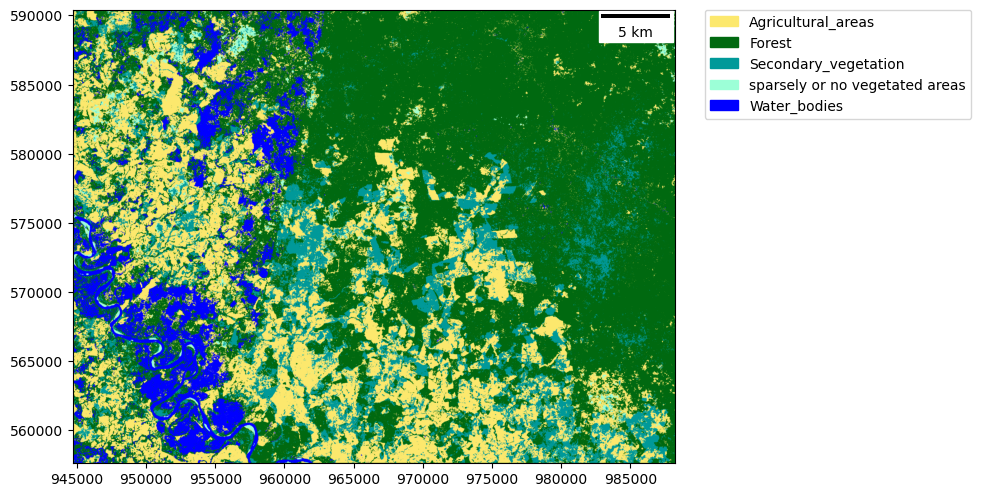

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rsgislib.tools.mapping

# Diccionario de clases y colores RGB (ejemplo)
class_labels = {
    "Agricultural_areas": (252, 232, 109),
    "Forest": (0, 105, 16),
    "Secondary_vegetation": (0, 153, 153),
    "sparsely or no vegetated areas": (156, 255, 215),
    "Water_bodies": (0, 0, 255)
}

# Convertir los colores RGB (0–255) a formato 0–1
def rgb_to_mpl(rgb):
    return tuple([v/255 for v in rgb])

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

# Mapa clasificado
rsgislib.tools.mapping.create_thematic_raster_map(
    ax=ax,
    input_img="clasificacion_rf_2018.kea"
)

# Crear leyenda personalizada
legend_patches = [
    mpatches.Patch(color=rgb_to_mpl(rgb), label=label)
    for label, rgb in class_labels.items()
]

# Añadir leyenda fuera del mapa
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

### Visualizar subconjuntos

Image Data Size: 4360 x 3288
Image Data Size: 4360 x 3288


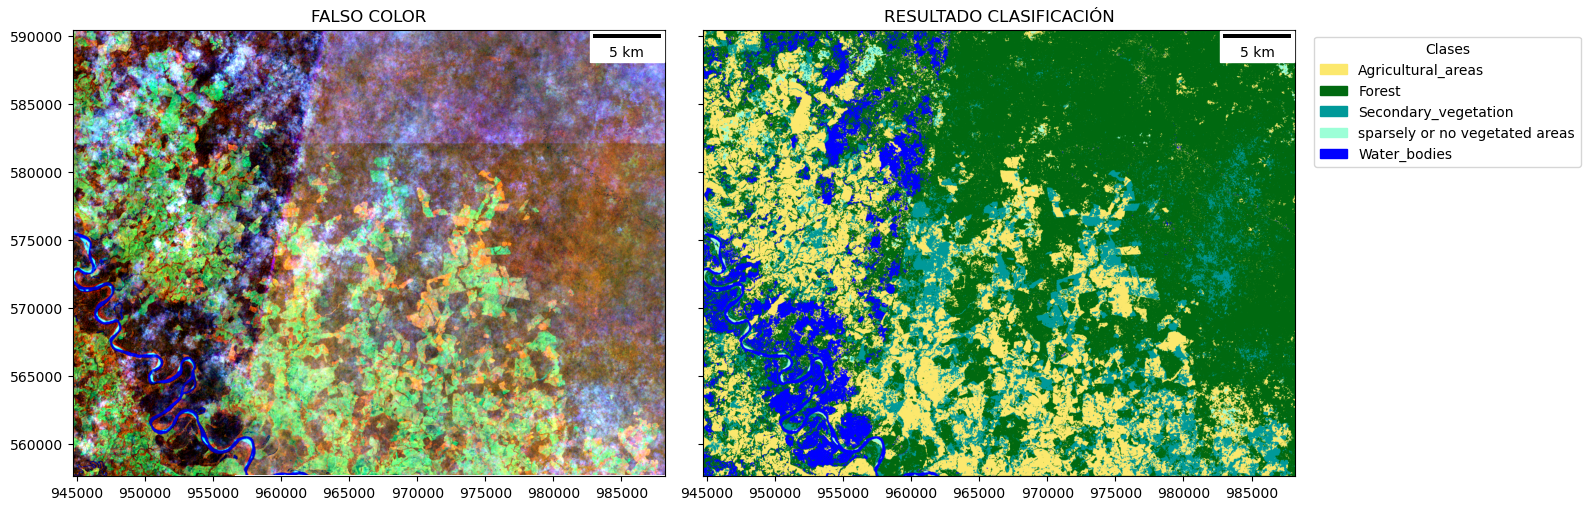

In [48]:
# Función para convertir de RGB 255 a escala 0–1
def rgb_to_mpl(rgb):
    return tuple([v / 255 for v in rgb])

# Crear diccionario de clases y colores desde cls_smpls_info
class_labels = {
    cls_name: (
        cls_smpls_info[cls_name].red,
        cls_smpls_info[cls_name].green,
        cls_smpls_info[cls_name].blue,
    )
    for cls_name in cls_smpls_info
}

# Subconjunto espacial
sub_img_bbox = [944712.7306693317, 988204.5931766616, 557628.0093751058, 590426.4598164133]

# Crear figura con dos mapas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Imagen en falso color
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)
ax1.title.set_text("FALSO COLOR")

# Imagen clasificada
rsgislib.tools.mapping.create_thematic_raster_map(
    ax2,
    input_img=out_cls_img,
    bbox=sub_img_bbox
)
ax2.title.set_text("RESULTADO CLASIFICACIÓN")

# Crear parches para la leyenda
legend_patches = [
    mpatches.Patch(color=rgb_to_mpl(rgb), label=label)
    for label, rgb in class_labels.items()
]

# Añadir la leyenda a la derecha del segundo mapa
ax2.legend(
    handles=legend_patches,
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    title="Clases"
)

plt.tight_layout()
plt.show()

## 10. Estimación de métricas de precisión

Una vez realizada la clasificación temática, es fundamental evaluar su precisión utilizando puntos de referencia. Este proceso se basa en comparar los resultados del clasificador con datos de referencia independientes (que idealmente no se usaron durante el entrenamiento).

### Declarar variables con la ruta a los puntos de evaluación

Para evaluar la precisión del clasificador, se utilizará un conjunto independiente de puntos de validación que no fueron usados durante el entrenamiento. Estos puntos están almacenados en un archivo vectorial (`Training.gpkg`) y contienen las clases reales del terreno, codificadas del 1 al 7.

En esta celda se declaran:
- `vec_file`: ruta al archivo `.gpkg` que contiene los puntos de validación.
- `vec_lyr`: nombre de la capa dentro del archivo.

Este archivo será comparado con el mapa clasificado para estimar métricas de precisión.

In [145]:
## Ruta al archivo vectorial con puntos de validación
vec_file = "data/Workshop_3/Testing_points_epsg3116.gpkg"

# Nombre de la capa que contiene los puntos
vec_lyr = "amazontesting"

### Crear directorios de salida

Para mantener el flujo de trabajo organizado, se crean dos carpetas:

- `acc_pts`: donde se almacenarán los puntos de validación en formato GeoJSON (si se exportan).
- `acc_stats`: donde se guardarán los resultados de las métricas de precisión (CSV y JSON).

Estas carpetas se crearán automáticamente si no existen.


In [146]:
# Directorio para puntos de evaluación (por si se exportan)
out_pts_dir = "acc_pts"
os.makedirs(out_pts_dir, exist_ok=True)

# Directorio para resultados de métricas
out_stats_dir = "acc_stats"
os.makedirs(out_stats_dir, exist_ok=True)

print("Directorios creados o verificados correctamente.")

Directorios creados o verificados correctamente.


### Exportar puntos de evaluación a GeoJSON

Aunque los puntos de validación ya se encuentran en un archivo `.gpkg`, se exportan a formato GeoJSON para facilitar la lectura con librerías como `geopandas`, que permiten realizar análisis personalizados.

> Esta exportación es útil para:
> - Extraer el valor clasificado (predicción) desde la imagen en la ubicación de cada punto.
> - Comparar la clase predicha con la clase real asignada en el atributo del punto.
> - Evaluar el desempeño del clasificador con métricas calculadas manualmente.

El archivo GeoJSON será utilizado junto a `rasterio` y `scikit-learn` para calcular precisión, matriz de confusión, F1-score, y otras métricas de desempeño.



Primero se generan las mismas etiquetas para los puntos de referencia.

In [147]:
# Leer la capa
points_gdf = gpd.read_file(vec_file, layer=vec_lyr)

rename_map = {
    1: "Agricultural_areas",
    2: "Forest",
    5: "Water_bodies",
    6: "Secondary_vegetation",
    8: "sparsely or no vegetated areas"
}

# Reemplazar los valores en la columna "Reference"
points_gdf["Reference"] = points_gdf["Reference"].replace(rename_map)
# Sobrescribir la misma capa en el mismo archivo
points_gdf.to_file(vec_file, layer=vec_lyr, driver="GPKG")

In [148]:
# Leer la capa
points_gdf = gpd.read_file(vec_file, layer=vec_lyr)

rename_map = {
    1: "Agricultural_areas",
    2: "Forest",
    5: "Water_bodies",
    3: "Secondary_vegetation",
    4: "sparsely or no vegetated areas"
}

# Extraer valores del raster clasificado para cada punto
points_gdf["Classified"] = point_query(points_gdf, "clasificacion_rf_2018.kea", interpolate='nearest')

# Reemplazar los valores en la columna "Reference"
points_gdf["Classified"] = points_gdf["Classified"].replace(rename_map)
# Sobrescribir la misma capa en el mismo archivo
points_gdf.to_file(vec_file, layer=vec_lyr, driver="GPKG")

In [149]:
# Archivo de salida en GeoJSON
vec_refpts_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref.geojson")
vec_refpts_lyr = "cls_acc_assessment_pts_ref"

# Exportar la capa desde el GPKG a GeoJSON
rsgislib.vectorutils.vector_translate(
    vec_file=vec_file,
    vec_lyr="amazontesting", 
    out_vec_file=vec_refpts_file,
    out_vec_lyr=vec_refpts_lyr,
    out_format="GeoJSON",
    del_exist_vec=True
)

print("Puntos de evaluación exportados a GeoJSON correctamente.")

Deleting: acc_pts/cls_acc_assessment_pts_ref.geojson






  0%|                                                                                           | 0/100 [00:00<?, ?it/s]



  1%|▊                                                                                  | 1/100 [00:00<00:14,  7.05it/s]

Puntos de evaluación exportados a GeoJSON correctamente.


### Visualización de puntos de validación

Image Data Size: 4360 x 3288


<Axes: >

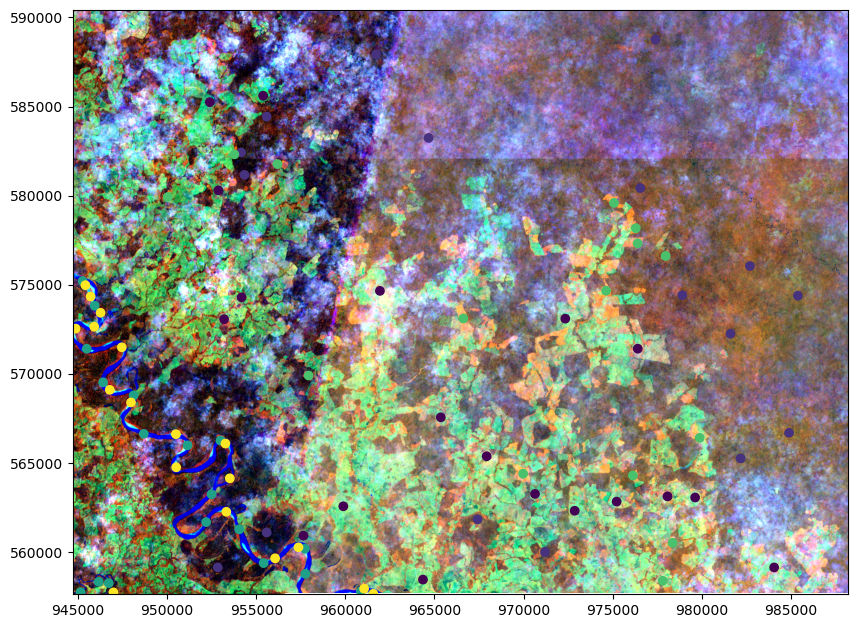

In [44]:
# Read image data
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))
# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# Read points to geopandas dataframe
points_gdf = geopandas.read_file(vec_refpts_file)
points_gdf 



# Plot the plots over the image data
# Note. Points are randomly coloured by reference class
points_gdf.plot(ax=ax, column='Reference')

In [150]:
points_gdf

Classified           Reference                       geometry
0   Agricultural_areas  Agricultural_areas  POINT (978076.798 563122.154)
1   Agricultural_areas  Agricultural_areas  POINT (957647.653 560918.123)
2   Agricultural_areas              Forest  POINT (959480.063 590390.022)
3               Forest              Forest  POINT (964668.937 583237.615)
4         Water_bodies        Water_bodies   POINT (951138.31 565984.646)
..                 ...                 ...                            ...
83  Agricultural_areas  Agricultural_areas  POINT (965356.311 567558.396)
84  Agricultural_areas  Agricultural_areas  POINT (964354.399 558451.568)
85  Agricultural_areas  Agricultural_areas  POINT (952392.555 585244.743)
86  Agricultural_areas  Agricultural_areas  POINT (955386.042 585605.342)
87  Agricultural_areas  Agricultural_areas  POINT (967928.597 565374.101)

[88 rows x 3 columns]

### Poblar puntos de referencia

In [151]:
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=out_cls_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="Classified",
    vec_ref_col=None,
    vec_process_col=None,
)

/tmp/ipykernel_68/1421418499.py:1: RuntimeWarning: Field 'Classified' already exists. Renaming it as 'Classified2'
  rsgislib.classification.pop_class_info_accuracy_pts(


In [152]:
points_gdf = geopandas.read_file(vec_refpts_file)
points_gdf

Classified           Reference                       geometry
0   Agricultural_areas  Agricultural_areas  POINT (978076.798 563122.154)
1   Agricultural_areas  Agricultural_areas  POINT (957647.653 560918.123)
2   Agricultural_areas              Forest  POINT (959480.063 590390.022)
3               Forest              Forest  POINT (964668.937 583237.615)
4         Water_bodies        Water_bodies   POINT (951138.31 565984.646)
..                 ...                 ...                            ...
83  Agricultural_areas  Agricultural_areas  POINT (965356.311 567558.396)
84  Agricultural_areas  Agricultural_areas  POINT (964354.399 558451.568)
85  Agricultural_areas  Agricultural_areas  POINT (952392.555 585244.743)
86  Agricultural_areas  Agricultural_areas  POINT (955386.042 585605.342)
87  Agricultural_areas  Agricultural_areas  POINT (967928.597 565374.101)

[88 rows x 3 columns]

### Filtrar puntos válidos

Algunos clasificadores pueden generar regiones sin datos (no data), y si estas regiones se intersectan con puntos de referencia, se producirá un error al calcular las estadísticas de precisión. Por eso, necesitamos eliminar esos puntos, lo cual haremos utilizando geopandas.
Para los puntos donde no hay clase (es decir, son no data en la clasificación de entrada), se asigna el valor "NA" en la tabla de atributos, y son precisamente esas filas con valor "NA" las que queremos eliminar.

In [153]:
vec_refpts_vld_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref_vld.geojson")
vec_refpts_vld_lyr = "cls_acc_assessment_pts_ref_vld"
print(points_gdf )
points_gdf = points_gdf.drop(points_gdf[points_gdf["Classified"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")

            Classified           Reference                       geometry
0   Agricultural_areas  Agricultural_areas  POINT (978076.798 563122.154)
1   Agricultural_areas  Agricultural_areas  POINT (957647.653 560918.123)
2   Agricultural_areas              Forest  POINT (959480.063 590390.022)
3               Forest              Forest  POINT (964668.937 583237.615)
4         Water_bodies        Water_bodies   POINT (951138.31 565984.646)
..                 ...                 ...                            ...
83  Agricultural_areas  Agricultural_areas  POINT (965356.311 567558.396)
84  Agricultural_areas  Agricultural_areas  POINT (964354.399 558451.568)
85  Agricultural_areas  Agricultural_areas  POINT (952392.555 585244.743)
86  Agricultural_areas  Agricultural_areas  POINT (955386.042 585605.342)
87  Agricultural_areas  Agricultural_areas  POINT (967928.597 565374.101)

[88 rows x 3 columns]


In [154]:
# Get unique values
print( points_gdf["Reference"].unique())

['Agricultural_areas' 'Forest' 'Water_bodies' 'Secondary_vegetation'
 'sparsely or no vegetated areas']


### Calcular la precisión de la clasificación con RSGISLib

RSGISLib proporciona un par de funciones para este propósito, y utilizaremos la función calc_acc_metrics_vecsamples.

In [155]:
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples_img


out_json_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.json")
out_csv_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.csv")

calc_acc_metrics_vecsamples_img(
    vec_file=vec_refpts_vld_file,
    vec_lyr=vec_refpts_vld_lyr,
    ref_col="Reference",
    cls_col="Classified",
    cls_img=out_cls_img,
    img_cls_name_col="class_names",
    img_hist_col="Histogram",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file,
)

{np.str_('Agricultural_areas'): {'precision': 0.9,
  'recall': 0.9473684210526315,
  'f1-score': 0.9230769230769231,
  'support': 19.0},
 np.str_('Forest'): {'precision': 0.9285714285714286,
  'recall': 0.7222222222222222,
  'f1-score': 0.8125,
  'support': 18.0},
 np.str_('Secondary_vegetation'): {'precision': 0.9285714285714286,
  'recall': 0.8666666666666667,
  'f1-score': 0.896551724137931,
  'support': 15.0},
 np.str_('Water_bodies'): {'precision': 0.8095238095238095,
  'recall': 0.9444444444444444,
  'f1-score': 0.8717948717948718,
  'support': 18.0},
 np.str_('sparsely or no vegetated areas'): {'precision': 0.9473684210526315,
  'recall': 1.0,
  'f1-score': 0.972972972972973,
  'support': 18.0},
 'accuracy': 0.8977272727272727,
 'macro avg': {'precision': 0.9028070175438596,
  'recall': 0.896140350877193,
  'f1-score': 0.8953792983965398,
  'support': 88.0},
 'weighted avg': {'precision': 0.9018967874231033,
  'recall': 0.8977272727272727,
  'f1-score': 0.8956540750721786,
  'su

### Visualización métricas de precisión

En esta sección se utilizan funciones de `scikit-learn` para generar:

- **Exactitud global**
- **Matriz de confusión**
- **Reporte de clasificación** con precisión, recall y F1-score por clase

Esto permite evaluar cuantitativamente el desempeño del modelo y detectar clases donde hay mayor confusión.


In [156]:
pd.crosstab(points_gdf["Reference"], points_gdf["Classified"])

Classified                      Agricultural_areas  Forest  \
Reference                                                    
Agricultural_areas                              18       0   
Forest                                           1      13   
Secondary_vegetation                             1       1   
Water_bodies                                     0       0   
sparsely or no vegetated areas                   0       0   

Classified                      Secondary_vegetation  Water_bodies  \
Reference                                                            
Agricultural_areas                                 1             0   
Forest                                             0             4   
Secondary_vegetation                              13             0   
Water_bodies                                       0            17   
sparsely or no vegetated areas                     0             0   

Classified                      sparsely or no vegetated areas  
Reference                                                       
Agricultural_areas                                           0  
Forest                                                       0  
Secondary_vegetation                                         0  
Water_bodies                                                 1  
sparsely or no vegetated areas                              18

In [157]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo los puntos que sí fueron clasificados (evita NaN)
valid_points = points_gdf.dropna(subset=["Classified"])

# Asignar valores reales
y_true = valid_points["Reference"].astype(str)
y_pred = valid_points["Classified"].astype(str)

# 2. Obtener las clases únicas ordenadas (garantiza consistencia en el reporte)
unique_classes = sorted(set(y_true.unique()) | set(y_pred.unique()))

In [158]:
print("📊 Reporte de clasificación:")
print(classification_report(
    y_true, 
    y_pred, 
    labels=unique_classes,
    target_names=unique_classes,
    digits=3
))

📊 Reporte de clasificación:
                                precision    recall  f1-score   support

            Agricultural_areas      0.900     0.947     0.923        19
                        Forest      0.929     0.722     0.812        18
          Secondary_vegetation      0.929     0.867     0.897        15
                  Water_bodies      0.810     0.944     0.872        18
sparsely or no vegetated areas      0.947     1.000     0.973        18

                      accuracy                          0.898        88
                     macro avg      0.903     0.896     0.895        88
                  weighted avg      0.902     0.898     0.896        88



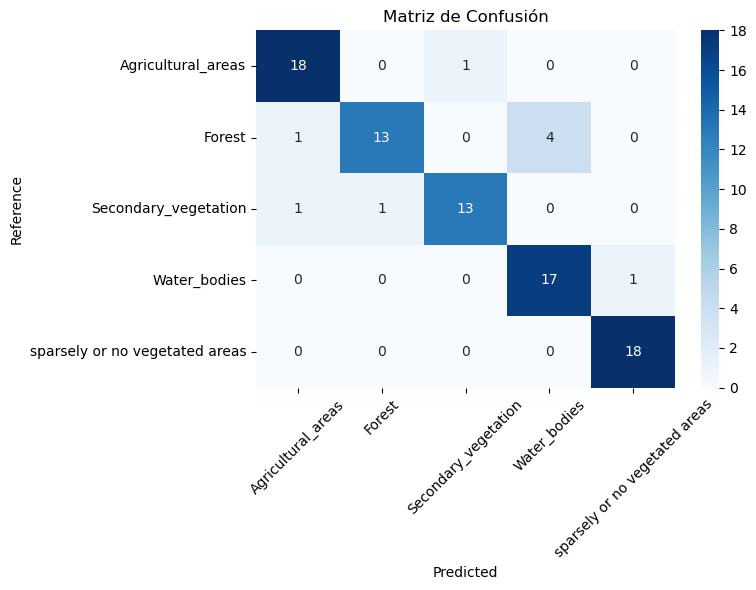

In [159]:
conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Reference")
plt.title("Matriz de Confusión")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [160]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Exactitud global: {accuracy * 100:.2f}%")


✅ Exactitud global: 89.77%


### Interpretación de resultados

Los resultados de la evaluación de precisión muestran un desempeño general positivo del clasificador Random Forest aplicado sobre el área de estudio, alcanzando una **exactitud global del 89.77%**.

A continuación se destacan algunos aspectos clave:

#### 🔍 Desempeño por clase
- **Sparsely or no vegetated areas**: fue la clase mejor clasificada, con una precisión del 94.7% y un recall del 100%, lo que indica que fue reconocida consistentemente sin errores de omisión.

- **Agricultural areas** también tuvo muy buen desempeño (precisión 90.0%, recall 94.7%), aunque se observan algunas confusiones con otras clases.

- **Secondary vegetation** presentó un rendimiento destacado (precisión 92.9%, recall 86.7%), aunque muestra ligeras sobreclasificaciones.

- **Water bodies** logró 81.0% de precisión y 94.4% de recall, lo que indica buena detección pero cierta propensión a clasificar erróneamente otras clases como cuerpos de agua.

- **Forest** fue la clase con menor recall (72.2%), a pesar de su alta precisión (92.9%), lo que sugiere una subdetección por parte del modelo.

#### 📊 Análisis de la matriz de confusión
- Se observan confusiones menores entre Agricultural areas y Forest, así como entre Secondary vegetation y Agricultural areas.
- La matriz muestra una diagonal dominante, lo que indica que en la mayoría de los casos el modelo predijo correctamente la clase correspondiente.

#### 📈 Métricas globales
Macro average:

Precisión: 90.28%

Recall: 89.61%

F1-score: 89.53%

Weighted average:

Precisión: 90.19%

Recall: 89.77%

F1-score: 89.57%

Cohen’s Kappa: 0.87

MCC (Matthews correlation coefficient): 0.87
#### ✅ Conclusión
El clasificador muestra un rendimiento general sólido, con una excelente capacidad para identificar las clases principales del paisaje. Las diferencias de desempeño por clase ofrecen oportunidades de mejora, particularmente en la clase Forest, donde se observaron omisiones. Además, podría considerarse aplicar estrategias de posprocesamiento para reducir los falsos positivos en clases como Water bodies y Secondary vegetation.



## 11. 